In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import rankdata
import sklearn
from keras.layers import Input, Dense, Conv1D, Conv2DTranspose,Lambda,Flatten,Reshape
from keras.models import Model
import pandas as pd
import numpy as np
from keras import regularizers
from keras import backend as K
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
from keras.losses import MAPE, cosine_similarity, MSLE, mae
import tensorflow as tf
from sklearn import metrics,svm
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
loaded_model = tf.keras.models.model_from_json(open('loaded_model_v2_sqrtmse_loss.json').read())
loaded_model.load_weights("loaded_model_v2_sqrtmse_loss.h5")
loaded_model.compile(optimizer='RMSprop')
#loaded_model.summary()

In [3]:
X = pd.read_csv("average_profile_no_outlier.csv",index_col=[0,1,2])
X = X.iloc[np.random.randint(0,X.shape[0],300),:]
X += np.random.randn(*X.shape)*0.01
neg = pd.read_csv("spectrum_avg_norm.csv",index_col=0).iloc[:3,:]
neg = pd.concat((neg,pd.read_csv("feuille_spectrum_avg_norm.csv",index_col=0)))
neg = neg.iloc[np.random.randint(0,3,300),:]
neg += np.random.randn(*neg.shape)*0.01
Spectre_test = pd.read_csv("../test_spectrum_avg_norm.csv",index_col=0)
#Spectre_test


In [4]:
#print(X.index)
#X.loc[True]


In [35]:

from keras.layers import Input, Dense, Conv1D, Conv2DTranspose,Lambda,Flatten,Reshape
from keras.models import Model
import pandas as pd
import numpy as np
from keras import regularizers
from keras import backend as K
from keras.utils import plot_model


def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same', activation="relu"):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding,activation=activation)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x


latent_dim = 2 
inputs = Input(shape=(448,))
x = Dense(448, activation='relu')(inputs)
x = Reshape((448,1, ))(x)
filters = 16
kernel_size=3
for i in range(2):
    filters *= 2
    x = Conv1D(filters,
               kernel_size,
               padding='same',
               activation='relu',
               strides=2)(x)
shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)



latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], ))(x)

for i in range(1):
    x = Conv1DTranspose(input_tensor=x,
                        filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')
    filters //= 2

outputs = Conv1DTranspose(x,
                          filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same')
outputs = Flatten()(outputs)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
#decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
loaded_model = Model(inputs, outputs, name='loaded_model')

plot_model(loaded_model, to_file='loaded_model.png', show_shapes=True)



IndentationError: unindent does not match any outer indentation level (<tokenize>, line 17)

In [7]:

from keras.losses import mse, binary_crossentropy
from keras.losses import MAPE, cosine_similarity, MSLE, mae

reconstruction_loss = K.sqrt(mse(K.flatten(inputs), K.flatten(outputs)))
reconstruction_loss *= 1*448 #10*448
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
loaded_model.add_loss(vae_loss)

loaded_model.compile(optimizer='adam')#RMSprop

#loaded_model.compile(loss=mse, optimizer='RMSprop')
loaded_model.summary()
X_train, X_test, y_train, y_test = train_test_split(X, neg, test_size=0.2, random_state=42)
loaded_model.fit(X_train, epochs=2000, batch_size=128)



''

In [29]:
loaded_model.fit(X_train, epochs=1000, batch_size=48)

In [8]:
#X_train, X_test, y_train, y_test = train_test_split(X, neg, test_size=0.2, random_state=42)

print(loaded_model.history)
print(K.flatten(outputs))
#vae.add_loss(K.mean(reconstruction_loss + kl_loss))
#print(vae_loss)
#print(K.mean(1))
#plot_model(vae, to_file='vae_cnn.png', show_shapes=True)
plt.plot((loaded_model.history.history["loss"]))
#plt.ylim(0,40)


None


NameError: name 'outputs' is not defined

In [9]:
decoded_X_test = loaded_model.predict(X_test)
decoded_neg = loaded_model.predict(neg)
decoded_Spectre_test = loaded_model.predict(Spectre_test)

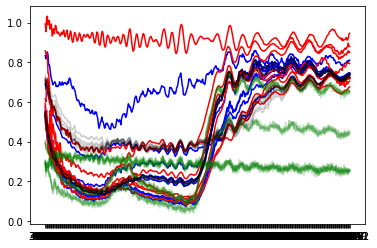

In [10]:
#plt.plot(decoded_X.T)
plt.plot(decoded_Spectre_test.T, "b")
plt.plot(Spectre_test.T, "red")
plt.plot(neg[:20].T,"green", alpha = 0.2)
plt.plot(decoded_neg[:20].T , "black", alpha = 0.2)
plt.show()

In [11]:
lim_inf = 0
lim_sup = 448

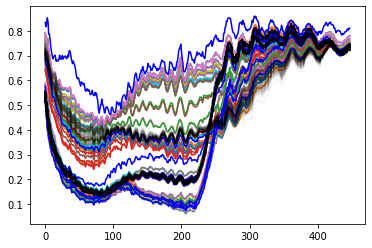

In [12]:
plt.plot(decoded_X_test[:, lim_inf:lim_sup].T)
plt.plot(decoded_Spectre_test[:,lim_inf:lim_sup].T, "b")
plt.plot(decoded_neg[:, lim_inf:lim_sup].T , "black", alpha = 0.04)
plt.show()

In [13]:
"""
mse_feuille = np.array(mse(decoded_neg,neg.iloc))
mse_puceron = np.array(mse(decoded_X, X.iloc))
mse_Spectre = np.array(mse(decoded_Spectre_test, Spectre_test.iloc))
"""

mse_feuille = np.array(mse(decoded_neg[:,lim_inf:lim_sup],neg.iloc[:,lim_inf:lim_sup]))
mse_puceron = np.array(mse(decoded_X_test[:,lim_inf:lim_sup], X_test.iloc[:,lim_inf:lim_sup]))
mse_Spectre = np.array(mse(decoded_Spectre_test[:,lim_inf:lim_sup], Spectre_test.iloc[:,lim_inf:lim_sup]))


sqrt_mse_p = np.array(np.sqrt(mse(decoded_X_test[:,lim_inf:lim_sup], X_test.iloc[:,lim_inf:lim_sup])))
sqrt_mse_f = np.array(np.sqrt(mse(decoded_neg[:,lim_inf:lim_sup], neg.iloc[:,lim_inf:lim_sup])))
sqrt_Spectre = np.array(np.sqrt(mse(decoded_Spectre_test[:,lim_inf:lim_sup], Spectre_test.iloc[:,lim_inf:lim_sup])))

mape_feuille = np.array(MAPE(decoded_neg[:,lim_inf:lim_sup], neg.iloc[:,lim_inf:lim_sup]))
mape_puceron = np.array(MAPE(decoded_X_test[:,lim_inf:lim_sup], X_test.iloc[:,lim_inf:lim_sup]))
mape_Spectre = np.array(MAPE(decoded_Spectre_test[:,lim_inf:lim_sup], Spectre_test.iloc[:,lim_inf:lim_sup]))

mselog_feuille = np.array(MSLE(decoded_neg[:,lim_inf:lim_sup], neg.iloc[:,lim_inf:lim_sup]))
mselog_puceron = np.array(MSLE(decoded_X_test[:,lim_inf:lim_sup], X_test.iloc[:,lim_inf:lim_sup]))
mselog_Spectre = np.array(MSLE(decoded_Spectre_test[:,lim_inf:lim_sup], Spectre_test.iloc[:,lim_inf:lim_sup]))

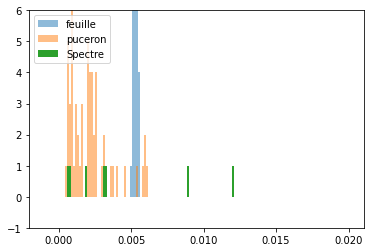

In [14]:
bins = np.linspace(-0.001, 0.02, 150)

plt.hist(mse_feuille, bins, alpha=0.5, label='feuille')
plt.hist(mse_puceron, bins, alpha=0.5, label='puceron')
plt.hist(mse_Spectre, bins, alpha=1, label = "Spectre")
plt.ylim(-1,6)
plt.legend(loc='upper left')


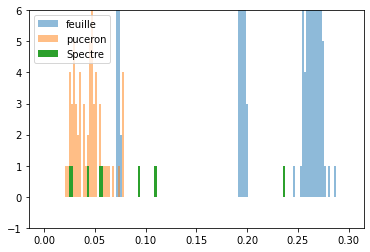

In [15]:
bins = np.linspace(-0.0, 0.3, 150)

plt.hist(sqrt_mse_f, bins, alpha=0.5, label='feuille')
plt.hist(sqrt_mse_p, bins, alpha=0.5, label='puceron')
plt.hist(sqrt_Spectre, bins, alpha=1, label = "Spectre")
plt.ylim(-1,6)
plt.legend(loc='upper left')

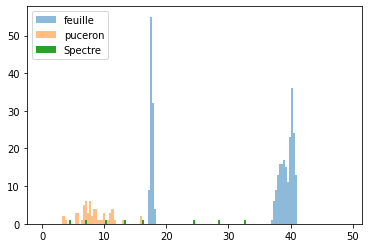

In [16]:
bins = np.linspace(-0.01, 49, 150)

plt.hist(mape_feuille, bins, alpha=0.5, label='feuille')
plt.hist(mape_puceron, bins, alpha=0.5, label='puceron')
plt.hist(mape_Spectre, bins, alpha=1, label = "Spectre")
plt.legend(loc='upper left')

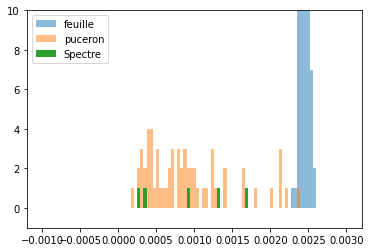

In [17]:
bins = np.linspace(-0.001, 0.003, 100)

plt.hist(mselog_feuille, bins, alpha=0.5, label='feuille')
plt.hist(mselog_puceron, bins, alpha=0.5, label='puceron')
plt.hist(mselog_Spectre, bins, alpha=1, label = "Spectre")
plt.ylim(-1,10)
plt.legend(loc='upper left')

In [18]:
MSE_train, MSE_test = train_test_split(mse_puceron, test_size=0.2, random_state=42)
MSE_train = np.array(MSE_train).reshape(-1,1)
MSE_test = np.array(MSE_test).reshape(-1,1)

MSElog_train, MSElog_test = train_test_split(mselog_puceron, test_size=0.2, random_state=42)
MSElog_train = np.array(MSElog_train).reshape(-1,1)
MSElog_test = np.array(MSElog_test).reshape(-1,1)

Sqrt_MSE_train, Sqrt_MSE_test = train_test_split(sqrt_mse_p, test_size=0.2, random_state=42)
Sqrt_MSE_train = np.array(Sqrt_MSE_train).reshape(-1,1)
Sqrt_MSE_test = np.array(Sqrt_MSE_test).reshape(-1,1)

In [19]:
from sklearn import svm
clf = svm.OneClassSVM(kernel="rbf", gamma="auto")
clf.fit(MSE_train)

clflog = svm.OneClassSVM(kernel="rbf", gamma="auto")
clflog.fit(MSElog_train)

clfsqrt = svm.OneClassSVM(kernel="rbf", gamma="auto")
clfsqrt.fit(Sqrt_MSE_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

In [20]:

y_pred_train = clf.predict(MSE_train)
y_pred_test = clf.predict(MSE_test)
PREDICTION_SPECTRE = clf.predict(np.array(mse_Spectre).reshape(-1,1))
y_pred_neg = clf.predict(mse_feuille.reshape(-1, 1))
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size



In [21]:
#print(y_pred_train)
#print(y_pred_neg)
#print(y_pred_test)



print("\n Prediction du spectre :")
list_pred = []
for i,e in enumerate(Spectre_test.index):
    list_pred.append((str(e)+" : "+str(PREDICTION_SPECTRE[i])))
#print(Spectre_test.index)
#print(PREDICTION_SPECTRE)
print(list_pred)
"""
if (PREDICTION_SPECTRE == 1):
    print("   --CECI EST UN PUCERON --")
else:
    print("   --Pas puceron --")
"""
""


 Prediction du spectre :
['EXgr : -1', 'NA9R2 : 1', 'NA9R2F : 1', 'RA9R2F : -1', 'VAWR1F : 1', 'RL4R2F : 1', 'NL2R2F : 1', 'VL1grF : -1']


''

In [22]:
from sklearn import metrics
print("MSE : \n\n ------------- \n Train vs pred_train \n ")
print("Accuracy score : ", metrics.accuracy_score(y_pred_train, [1]*len(y_pred_train)))
print("f1 : ", metrics.f1_score(y_pred_train, [1]*len(y_pred_train)))
print("Jaccard : ", metrics.jaccard_score(y_pred_train, [1]*len(y_pred_train)))
print("Hamming loss : ", metrics.hamming_loss(y_pred_train, [1]*len(y_pred_train)))
print("\n ------------- \n Test vs pred_test \n ")
print("Accuracy score : ", metrics.accuracy_score(y_pred_test, [1]*len(y_pred_test)))
print("f1 : ", metrics.f1_score(y_pred_test, [1]*len(y_pred_test)))
print("Jaccard : ", metrics.jaccard_score(y_pred_test, [1]*len(y_pred_test)))
print("Hamming loss : ", metrics.hamming_loss(y_pred_test, [1]*len(y_pred_test)))
print("\n ------------- \n Neg vs pred_neg \n ")
print("Accuracy score : ", metrics.accuracy_score(y_pred_neg, [-1]*len(y_pred_neg)))



MSE : 

 ------------- 
 Train vs pred_train 
 
Accuracy score :  0.9166666666666666
f1 :  0.9565217391304348
Jaccard :  0.9166666666666666
Hamming loss :  0.08333333333333333

 ------------- 
 Test vs pred_test 
 
Accuracy score :  0.9166666666666666
f1 :  0.9565217391304348
Jaccard :  0.9166666666666666
Hamming loss :  0.08333333333333333

 ------------- 
 Neg vs pred_neg 
 
Accuracy score :  1.0


In [23]:
y_pred_train = clflog.predict(MSElog_train)
y_pred_test = clflog.predict(MSElog_test)
PREDICTION_SPECTRE = clflog.predict(np.array(mselog_Spectre).reshape(-1,1))
y_pred_neg = clflog.predict(mselog_feuille.reshape(-1, 1))
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size

In [24]:
#print(y_pred_train)
#print(y_pred_neg)
#print(y_pred_test)



print("\n Prediction du spectre :")
list_pred = []
for i,e in enumerate(Spectre_test.index):
    list_pred.append((str(e)+" : "+str(PREDICTION_SPECTRE[i])))
#print(Spectre_test.index)
#print(PREDICTION_SPECTRE)
print(list_pred)
from sklearn import metrics
print("\nMSElog : \n\n ------------- \n Train vs pred_train \n ")
print("Accuracy score : ", metrics.accuracy_score(y_pred_train, [1]*len(y_pred_train)))
print("f1 : ", metrics.f1_score(y_pred_train, [1]*len(y_pred_train)))
print("Jaccard : ", metrics.jaccard_score(y_pred_train, [1]*len(y_pred_train)))
print("Hamming loss : ", metrics.hamming_loss(y_pred_train, [1]*len(y_pred_train)))
print("\n ------------- \n Test vs pred_test \n ")
print("Accuracy score : ", metrics.accuracy_score(y_pred_test, [1]*len(y_pred_test)))
print("f1 : ", metrics.f1_score(y_pred_test, [1]*len(y_pred_test)))
print("Jaccard : ", metrics.jaccard_score(y_pred_test, [1]*len(y_pred_test)))
print("Hamming loss : ", metrics.hamming_loss(y_pred_test, [1]*len(y_pred_test)))
print("\n ------------- \n Neg vs pred_neg \n ")
print("Accuracy score : ", metrics.accuracy_score(y_pred_neg, [-1]*len(y_pred_neg)))
print("f1 : ", metrics.f1_score(y_pred_neg, [-1]*len(y_pred_neg)))
print("Jaccard : ", metrics.jaccard_score(y_pred_neg, [-1]*len(y_pred_neg)))
print("Hamming loss : ", metrics.hamming_loss(y_pred_neg, [-1]*len(y_pred_neg)))


 Prediction du spectre :
['EXgr : -1', 'NA9R2 : 1', 'NA9R2F : 1', 'RA9R2F : -1', 'VAWR1F : 1', 'RL4R2F : 1', 'NL2R2F : 1', 'VL1grF : -1']

MSElog : 

 ------------- 
 Train vs pred_train 
 
Accuracy score :  0.875
f1 :  0.9333333333333333
Jaccard :  0.875
Hamming loss :  0.125

 ------------- 
 Test vs pred_test 
 
Accuracy score :  0.9166666666666666
f1 :  0.9565217391304348
Jaccard :  0.9166666666666666
Hamming loss :  0.08333333333333333

 ------------- 
 Neg vs pred_neg 
 
Accuracy score :  1.0
f1 :  0.0
Jaccard :  0.0
Hamming loss :  0.0


/home/azurmely/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/azurmely/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
y_pred_train = clfsqrt.predict(Sqrt_MSE_train)
y_pred_test = clfsqrt.predict(Sqrt_MSE_test)
PREDICTION_SPECTRE = clfsqrt.predict(np.array(sqrt_Spectre).reshape(-1,1))
y_pred_neg = clfsqrt.predict(sqrt_mse_f.reshape(-1, 1))
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
print("\n Prediction du spectre :")
list_pred = []
for i,e in enumerate(Spectre_test.index):
    list_pred.append((str(e)+" : "+str(PREDICTION_SPECTRE[i])))
#print(Spectre_test.index)
#print(PREDICTION_SPECTRE)
print(list_pred)

print("\n SQRT MSE : \n\n ------------- \n Train vs pred_train \n ")
print("Accuracy score : ", metrics.accuracy_score(y_pred_train, [1]*len(y_pred_train)))
print("f1 : ", metrics.f1_score(y_pred_train, [1]*len(y_pred_train)))
print("Jaccard : ", metrics.jaccard_score(y_pred_train, [1]*len(y_pred_train)))
print("Hamming loss : ", metrics.hamming_loss(y_pred_train, [1]*len(y_pred_train)))
print("\n ------------- \n Test vs pred_test \n ")
print("Accuracy score : ", metrics.accuracy_score(y_pred_test, [1]*len(y_pred_test)))
print("f1 : ", metrics.f1_score(y_pred_test, [1]*len(y_pred_test)))
print("Jaccard : ", metrics.jaccard_score(y_pred_test, [1]*len(y_pred_test)))
print("Hamming loss : ", metrics.hamming_loss(y_pred_test, [1]*len(y_pred_test)))
print("\n ------------- \n Neg vs pred_neg \n ")
print("Accuracy score : ", metrics.accuracy_score(y_pred_neg, [-1]*len(y_pred_neg)))
print("f1 : ", metrics.f1_score(y_pred_neg, [-1]*len(y_pred_neg)))
print("Jaccard : ", metrics.jaccard_score(y_pred_neg, [-1]*len(y_pred_neg)))
print("Hamming loss : ", metrics.hamming_loss(y_pred_neg, [-1]*len(y_pred_neg)))


 Prediction du spectre :
['EXgr : -1', 'NA9R2 : -1', 'NA9R2F : 1', 'RA9R2F : -1', 'VAWR1F : -1', 'RL4R2F : -1', 'NL2R2F : -1', 'VL1grF : -1']

 SQRT MSE : 

 ------------- 
 Train vs pred_train 
 
Accuracy score :  0.5
f1 :  0.6666666666666666
Jaccard :  0.5
Hamming loss :  0.5

 ------------- 
 Test vs pred_test 
 
Accuracy score :  0.25
f1 :  0.4
Jaccard :  0.25
Hamming loss :  0.75

 ------------- 
 Neg vs pred_neg 
 
Accuracy score :  1.0
f1 :  0.0
Jaccard :  0.0
Hamming loss :  0.0


/home/azurmely/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/azurmely/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sauvegarde des modeles: 

In [170]:
"""
model = loaded_model
model_json = model.to_json()
with open("loaded_model_v2_sqrtmse_loss.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5 
model.save_weights("loaded_model_v2_sqrtmse_loss.h5")
print("Saved model to disk")
"""

Saved model to disk


In [28]:
"""
import joblib
# now you can save it to a file
joblib.dump(clf, 'SVM_spectral_classifier_MSE.pkl') 
# and later you can load it
clf = joblib.load('SVM_spectral_classifier_MSE.pkl')
"""